# How does unity integrate fictrac data?

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
from scipy.stats import vonmises, skew, kurtosis
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from unityvr.preproc import logproc as lp
from unityvr.viz import viz
from unityvr.analysis import posAnalysis, shapeAnalysis, fitting, utils


from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
dirName = '../sample/sample18'
fileName = 'Log_2025-01-13_16-11-35_trial_fictrac_late.json'
fileName

'Log_2025-01-13_16-11-35_trial_fictrac_late.json'

Get uvrTest object from log file. 

In [3]:
uvrTest = lp.constructUnityVRexperiment(dirName, fileName, fictracSubject='Not Integrated', posDfKey = 'attemptedTranslation')
#if using FictracSubjectIntegrated, set fictracSubject='Integrated' and posDfKey = 'worldPosition'
#posDfKey specifies the string that will be matched to find the chunk in the json that contains position data. For FictracSubjectIntegrated this is expected to be 'worldPosition', while for FictracSubject it is expected to be 'attemptedTranslation'.
uvrTest.printMetadata()

correcting for Unity angle convention.
Metadata:

expid  :  SS96-x-7f_dark
experiment  :  holder V2, closed loop panorama, 144 Hz frame rate, collected by Shivam
genotype  :  SS96-x-7f
sex  :  female
flyid  :  f03
trial  :  trialate
date  :  2025-01-13
time  :  16-11-35
ballRad  :  0.04699999839067459
translationalGain  :  1.0
setFrameRate  :  144
notes  :  EB
temperature  :  Room
angle_convention  :  right-handed


# Integration


### Fictrac integration

Get file `.dat` file from fictrac. Look at the `deltaRotationVectorLab` (see the [fictrac header](https://github.com/rjdmoore/fictrac/blob/master/doc/data_header.txt)). 

In [4]:
fictracData = pd.read_csv('../sample/sample18/fictrac-20250113_161140.dat', header= None).iloc[:,[5,6,7,14,15,16,24]].rename(columns={5:'dx',6:'dy',7:'dz',14:'x',15:'y',16:'angle',24:'time'})
fictracData['time'] = (fictracData.iloc[:,-1] - fictracData.iloc[0,-1])/1e3 # convert to seconds

In [5]:
fictracData.head()

,dx,dy,dz,x,y,angle,time
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.040695,0.014944,-0.154069,0.018015,-0.039388,0.154069,0.006118
2,0.341524,-0.017084,0.014560,0.051066,-0.379735,0.139509,0.012869
3,0.589652,0.033996,0.163978,0.118833,-0.965841,6.258716,0.019677
4,0.951713,0.238200,0.042105,0.313464,-1.927342,6.216611,0.026679


Check that integrating fictrac `dz` gives the integrated angle reported by fictrac. Note that the integration is done by [negating the angular change](https://www.sciencedirect.com/science/article/pii/S0165027014000211?via%3Dihub):

$$

\theta_k = \theta_{k-1} - \omega_z

$$

$k$ is a given video frame. Fictrac provides absolute estimates of $\theta_k$ which prevents error from compounding. 

In [6]:
fictracData['integrated_z'] = np.cumsum(-fictracData['dz'].values)%(2*np.pi)

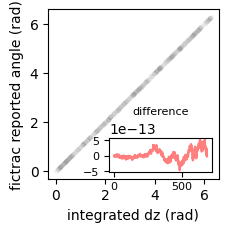

In [7]:
fig, ax = plt.subplots(figsize = (2.2,2.2))
ax.plot(fictracData['integrated_z'], fictracData['angle'], 'k.', alpha=0.01);
ax.set_xlabel('integrated dz (rad)')
ax.set_ylabel('fictrac reported angle (rad)');

ax_inset = inset_axes(ax, width="60%", height="20%", loc="lower right")  # Adjust size and position
ax_inset.plot(fictracData['angle']-fictracData['integrated_z'], color="red", alpha=0.5)
ax_inset.set_title("difference", fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=8)


Similarly integrate the x and y components of the velocity to get the x and y components of the position. Then, compare this with fictrac's reported x and y positions.

The integration is [reportedly performed in the following way](https://www.sciencedirect.com/science/article/pii/S0165027014000211?via%3Dihub): 

$$
\begin{bmatrix} 
x_k \\ 
y_k 
\end{bmatrix}

= 
\begin{bmatrix} 
x_{k-1} \\ 
y_{k-1} 
\end{bmatrix}

+ 

\begin{bmatrix} 
\cos\theta_k & -\sin\theta_k \\ 
\sin\theta_k & \cos\theta_k 
\end{bmatrix} 
\cdot 
\begin{bmatrix} 
\omega_y \\ 
-\omega_x 
\end{bmatrix}

$$

Note that $x_k$ depends on $x_{k-1}, \omega_x, \omega_y$ and $\Theta_k$. This means than an error in any of these values will propagate. 


To allow for smooth rotations, the [actual integration in fictrac is subtly different](https://github.com/rjdmoore/fictrac/blob/81aaac7820c1e8fa4862d77c749c82227c958305/src/Trackball.cpp#L960):

$$
\begin{bmatrix}
x_k \\
y_k
\end{bmatrix}
=
\begin{bmatrix}
x_{k-1} \\
y_{k-1}
\end{bmatrix}
+
\dfrac{1}{N} \sum_{s=1}^{N}
\mathbf{R}\left(\theta_{k-1} + (2s - 1) \cdot \frac{\Delta \theta_k}{2N}\right)
\cdot
\begin{bmatrix}
w_y \\
-w_x
\end{bmatrix}
$$

where $\Delta \theta_k = \text{unwrap}(\theta_k - \theta_{k-1}) $ is the total change in heading, $\mathbf{R}(\theta) $ is the 2D rotation matrix and $N$ is the number of steps. 

In [8]:
def rotation2D(vector, angle):
    R = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return np.matmul(R, vector)

In [9]:
def compute_xy_fictrac_naive(wx_series, wy_series, theta_k_series, initial_Px, initial_Py):
    
    n = len(wx_series)
    Px_series = np.zeros(n)
    Py_series = np.zeros(n)

    # Set initial values
    Px_series[0] = initial_Px
    Py_series[0] = initial_Py

    # Iterate through the time series
    for k in range(1, n):
        # Rotation matrix for time step k
        
        # Vector involving wx and wy
        omega_vector = np.array([wy_series[k], -wx_series[k]])
        
        # Perform the transformation
        result_vector = rotation2D(omega_vector, theta_k_series[k]) #note the k here
        
        # Add the previous term to the transformed vector
        Px_series[k] = Px_series[k - 1] + result_vector[0]
        Py_series[k] = Py_series[k - 1] + result_vector[1]
    
    return Px_series, Py_series

In [10]:
def compute_xy_fictrac_steps(wx_series, wy_series, theta_k_series, initial_Px, initial_Py, nsteps = 4):
    
    n = len(wx_series)
    Px_series = np.zeros(n)
    Py_series = np.zeros(n)

    # Set initial values
    Px_series[0] = initial_Px
    Py_series[0] = initial_Py

    # Iterate through the time series
    for k in range(1, n):
        #the integration process will be done in n steps, each updating the position and the heading

        #unwrap difference in heading
        dtheta = (((theta_k_series[k] - theta_k_series[k-1])-np.pi)%(2*np.pi)-np.pi)

        #initialize the net result of the integration
        result_vector = np.zeros(2)
        
        #initialize the omega vector
        omega_vector = np.array([wy_series[k], -wx_series[k]])

        #iterate through the steps
        for s in range(1,nsteps+1):
            rotated_w = rotation2D(omega_vector, theta_k_series[k-1] + (2*s-1)*dtheta/(2*nsteps))
            result_vector += rotated_w
        
        # Set the next position
        Px_series[k] = Px_series[k-1] + result_vector[0]/nsteps
        Py_series[k] = Py_series[k-1] + result_vector[1]/nsteps
    
    return Px_series, Py_series

In [11]:
def compute_xy_unity(wx_series, wy_series, theta_k_series, initial_Px, initial_Py):
    
    n = len(wx_series)
    Px_series = np.zeros(n)
    Py_series = np.zeros(n)

    # Set initial values
    Px_series[0] = initial_Px
    Py_series[0] = initial_Py

    # Iterate through the time series
    for k in range(1, n):
        # Rotation matrix for time step k
        
        # Vector involving wx and wy
        omega_vector = np.array([wy_series[k], wx_series[k]])
        
        # Perform the transformation
        result_vector = rotation2D(omega_vector, theta_k_series[k-1]) #note the k-1 here
        
        # Add the previous term to the transformed vector
        Px_series[k] = Px_series[k - 1] + result_vector[0]
        Py_series[k] = Py_series[k - 1] + result_vector[1]
    
    return Px_series, Py_series

Perform the calculation for fictrac values: 

In [12]:
# full fictrac calculation
fictracData['integrated_x'],fictracData['integrated_y'] = compute_xy_fictrac_steps(fictracData['dx'], fictracData['dy'], fictracData['integrated_z'], 0.0, 0.0
                                                                                   )

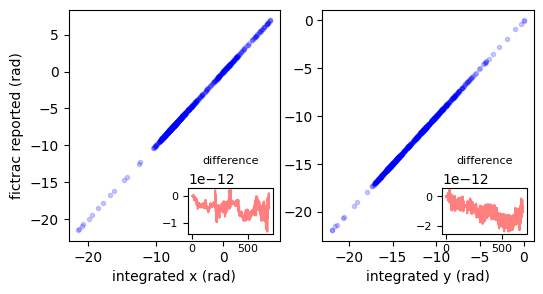

In [13]:
fig, ax = plt.subplots(1,2,figsize = (6,3))
for d, dim_str in enumerate(['x', 'y']):
    ax[d].plot(fictracData['integrated_'+dim_str], fictracData[dim_str], 'b.', alpha=0.2);
    ax[d].set_xlabel(f'integrated {dim_str} (rad)')
    if d<1: ax[d].set_ylabel(f'fictrac reported (rad)');

    ax_inset = inset_axes(ax[d], width="40%", height="20%", loc="lower right")  # Adjust size and position
    ax_inset.plot(fictracData[dim_str]-fictracData['integrated_'+dim_str], color="red", alpha=0.5)
    ax_inset.set_title("difference", fontsize=8)
    ax_inset.tick_params(axis='both', which='major', labelsize=8)

Show fictrac trajectory and integrated trajectory:

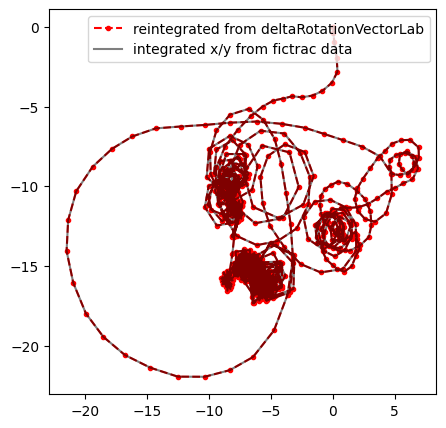

In [14]:
plt.figure(figsize = (5,5))
plt.plot(fictracData['integrated_x'], fictracData['integrated_y'],'r.--',label='reintegrated from deltaRotationVectorLab');  
plt.plot(fictracData['x'], fictracData['y'],'k-',alpha=0.5,label='integrated x/y from fictrac data'); 
plt.legend();

## Are fictrac values in the unity log and true fictrac values equivalent? 

Yes, unity faithfully logs fictrac values if required (check log fictrac box). These fictrac values can be compared to the fictrac values in the data file. 

In [15]:
unityDf = pd.merge(uvrTest.posDf, uvrTest.ftDf, on='frame', how='right', suffixes=('_unity', '_fictrac')).rename(columns={'dz':'dz_fictrac'})

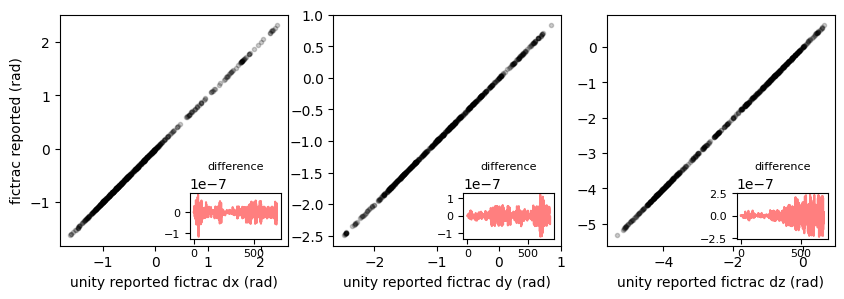

In [16]:
fig, ax = plt.subplots(1,3,figsize = (10,3))
for d, dim_str in enumerate(['dx', 'dy', 'dz']):
    ax[d].plot(unityDf[dim_str+'_fictrac'], fictracData[dim_str], 'k.', alpha=0.2);
    ax[d].set_xlabel(f'unity reported fictrac {dim_str} (rad)')
    if d<1: ax[d].set_ylabel(f'fictrac reported (rad)');

    ax_inset = inset_axes(ax[d], width="40%", height="20%", loc="lower right")  # Adjust size and position
    ax_inset.plot(unityDf[dim_str+'_fictrac']-fictracData[dim_str], color="red", alpha=0.5)
    ax_inset.set_title("difference", fontsize=8)
    ax_inset.tick_params(axis='both', which='major', labelsize=8)

## How does unity compute forward and sideways velocity for each frame?  

Unity logs the summed up `dx`(forward) and `dy`(sideways) value for each frame. Take the fictrac values logged in unity and for each frame, sum up the `dx`, `dy` and `dz` values independantly if there are more than 1 for each frame. Note here that the `dx` value reported by fictrac is converted into `dy` in the `posDf` dataframe and vice versa. First note that not all frames have a fictrac update. 

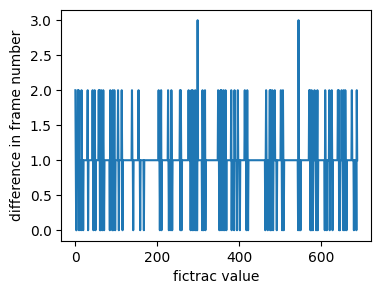

In [17]:
plt.figure(figsize = (4,3))
plt.plot(np.diff(unityDf['frame']))
plt.xlabel('fictrac value')
plt.ylabel('difference in frame number');

In [18]:
sumFtDf = unityDf.copy().groupby('frame')[['dx_fictrac', 'dy_fictrac', 'dz_fictrac']].sum().reset_index()
allFrameDf = pd.merge(sumFtDf, pd.DataFrame(np.arange(sumFtDf['frame'].values.min(), sumFtDf['frame'].values.max()+1), columns = ['frame']), how = 'right', on = 'frame').fillna(0.0)

In [19]:
uniqueFrameDf = pd.merge(uvrTest.posDf, allFrameDf, on='frame', how='inner').rename(columns = {'dx':'dy', 'dy':'dx'})

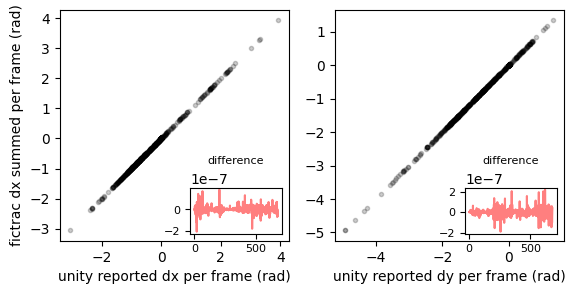

In [20]:
fig, ax = plt.subplots(1,2,figsize = (6.5,3))
for d, dim_str in enumerate(['dx', 'dy']):
    ax[d].plot(uniqueFrameDf[dim_str+'_fictrac'], uniqueFrameDf[dim_str]/uvrTest.metadata['ballRad'], 'k.', alpha=0.2);
    ax[d].set_xlabel(f'unity reported {dim_str} per frame (rad)')
    if d<1: ax[d].set_ylabel(f'fictrac dx summed per frame (rad)');

    ax_inset = inset_axes(ax[d], width="40%", height="20%", loc="lower right")  # Adjust size and position
    ax_inset.plot(uniqueFrameDf[dim_str+'_fictrac']-uniqueFrameDf[dim_str]/uvrTest.metadata['ballRad'], color="red", alpha=0.5)
    ax_inset.set_title("difference", fontsize=8)
    ax_inset.tick_params(axis='both', which='major', labelsize=8)

## How does unity compute heading? 

Similar to `dx`, the total `dz` per frame is summed up to provide a per frame estimate of change in rotation of the animal's heading. Note that Unity has flipped `y` axis relative to fictrac, giving a left handed convention. When extracted in `posDf['angle']`, the angle from unity is flipped for an equivalent right handed convention. 

The equivalent integration, à la fictrac, is as follows:

$$\theta_k = \theta_{k-1} + \omega_z$$

In [21]:
uniqueFrameDf['integrated_z'] = np.cumsum(uniqueFrameDf['dz_fictrac'])%(2*np.pi) #actual unity integration

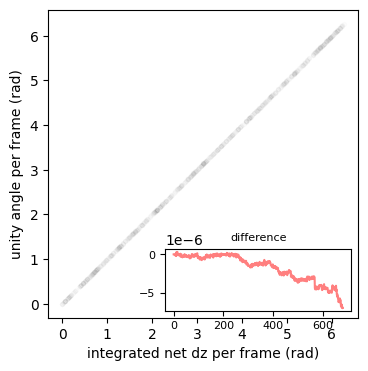

In [22]:
fig, ax = plt.subplots(figsize = (4,4))
ax.plot(uniqueFrameDf['integrated_z'], np.deg2rad(uniqueFrameDf['angle'])%(2*np.pi), 'k.', alpha=0.01);
ax.set_xlabel('integrated net dz per frame (rad)')
ax.set_ylabel('unity angle per frame (rad)');

ax_inset = inset_axes(ax, width="60%", height="20%", loc="lower right")  # Adjust size and position
ax_inset.plot(np.deg2rad(uniqueFrameDf['angle'])%(2*np.pi)-uniqueFrameDf['integrated_z'], color="red", alpha=0.5)
ax_inset.set_title("difference", fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=8)

## Is unity and the reported fictrac integration equivalent? 

Yes, unity does integrate fictrac values as reported in the fictrac paper in accordance with the difference in convention. However, note unity translates the object before rotating the heading, which leads to the following update equation:

$$
\begin{bmatrix} 
x_k \\ 
y_k
\end{bmatrix} 

= 
\begin{bmatrix} 
x_{k-1} \\ 
y_{k-1}
\end{bmatrix}

+ 

\begin{bmatrix} 
\cos\theta_{k-1} & -\sin\theta_{k-1} \\ 
\sin\theta_{k-1} & \cos\theta_{k-1}
\end{bmatrix} 
\cdot 
\begin{bmatrix} 
\omega_y \\ 
\omega_x 
\end{bmatrix}

$$

In [23]:
## full unity integration #angle was in a previous cell
uniqueFrameDf['integrated_x'], uniqueFrameDf['integrated_y'] = compute_xy_unity(uniqueFrameDf['dx_fictrac'].values, uniqueFrameDf['dy_fictrac'].values, uniqueFrameDf['integrated_z'].values, 0.0, 0.0)

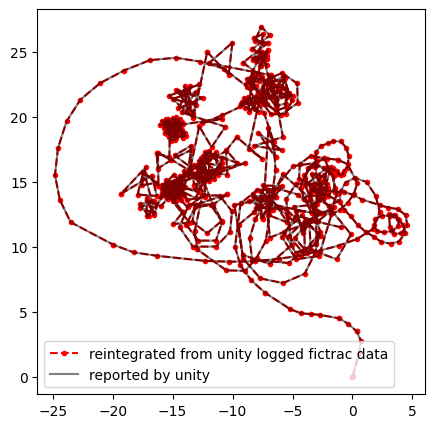

In [24]:
plt.figure(figsize = (5,5))
plt.plot(uniqueFrameDf['integrated_x'], uniqueFrameDf['integrated_y'],'r.--',label='reintegrated from unity logged fictrac data');  
plt.plot(uniqueFrameDf['x']/uvrTest.metadata['ballRad'], uniqueFrameDf['y']/uvrTest.metadata['ballRad'],'k-',alpha=0.5,label='reported by unity'); 
plt.legend();

# Testing Fictrac Sample Rate

Text(0.5, 0, 'Hz')

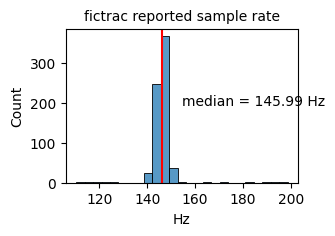

In [25]:
plt.figure(figsize=(3,2))
sns.histplot(1/(np.diff(fictracData['time'])), bins = 25);
plt.title('fictrac reported sample rate', fontsize = 10)
plt.axvline(1/np.median(np.diff(fictracData['time'])), color='r');
median = np.round(1/np.median(np.diff(fictracData['time'])),2)
plt.text(0.5, 0.5, f'median = {median} Hz', transform=plt.gca().transAxes);
plt.xlabel('Hz')

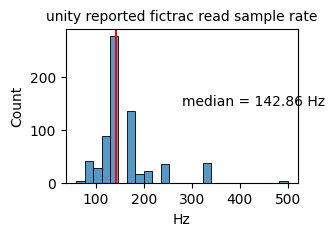

In [26]:
plt.figure(figsize=(3,2))
plt.title('unity reported fictrac read sample rate', fontsize = 10)
sns.histplot(1/(np.diff(unityDf['ficTracTReadMs']/1e3)), bins = 25);
median = np.round(np.median(1/(np.diff(unityDf['ficTracTReadMs']/1e3))),2)
plt.axvline(median, color='r');
plt.text(0.5, 0.5, f'median = {median} Hz', transform=plt.gca().transAxes);
plt.xlabel('Hz');

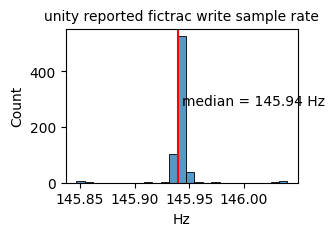

In [27]:
plt.figure(figsize=(3,2))
plt.title('unity reported fictrac write sample rate', fontsize = 10)
sns.histplot(1/np.diff(unityDf['ficTracTWriteMs']/1e9), bins = 25);
median = np.round(np.median(1/np.diff(unityDf['ficTracTWriteMs']/1e9)),2)
plt.axvline(median, color='r');
plt.text(0.5, 0.5, f'median = {median} Hz', transform=plt.gca().transAxes);
plt.xlabel('Hz');

### Time difference from fictrac log vs. time difference from unity log

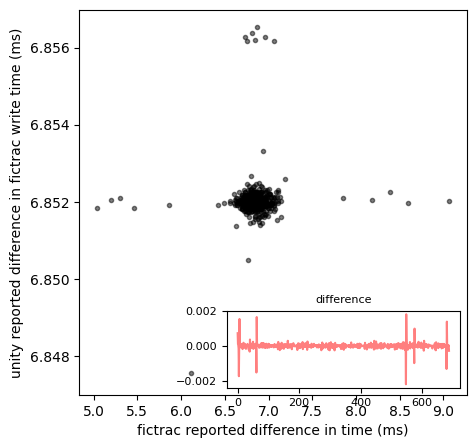

In [28]:
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(np.diff(fictracData['time'])*1e3, np.diff(unityDf['ficTracTWriteMs']/1e9)*1e3, 'k.', alpha=0.5);
ax.set_ylabel('unity reported difference in fictrac write time (ms)')
ax.set_xlabel('fictrac reported difference in time (ms)');

ax_inset = inset_axes(ax, width="60%", height="20%", loc="lower right")  # Adjust size and position
ax_inset.plot(np.diff(unityDf['ficTracTWriteMs']/1e9)-np.diff(fictracData['time']), color="red", alpha=0.5)
ax_inset.set_title("difference", fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=8)

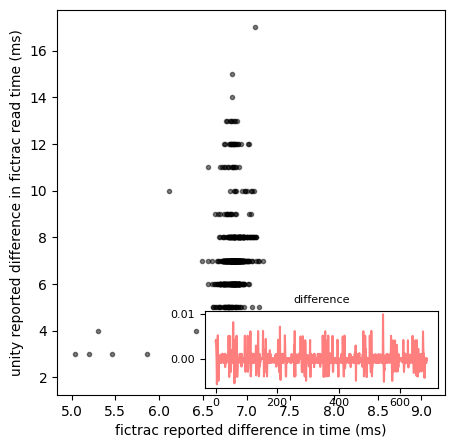

In [29]:
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(np.diff(fictracData['time'])*1e3, np.diff(unityDf['ficTracTReadMs']/1e3)*1e3, 'k.', alpha=0.5);
ax.set_ylabel('unity reported difference in fictrac read time (ms)')
ax.set_xlabel('fictrac reported difference in time (ms)');

ax_inset = inset_axes(ax, width="60%", height="20%", loc="lower right")  # Adjust size and position
ax_inset.plot(np.diff(unityDf['ficTracTReadMs']/1e3)-np.diff(fictracData['time']), color="red", alpha=0.5)
ax_inset.set_title("difference", fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=8)

## Derive dx and dy from x, y and heading

,frame,time,dt,x,y,angle,forward,right,dxattempt,dyattempt,forward,right,ds,s,dTh,radangle,forward,right,dx,dy
0,303.0,0.000000,0.006966,0.000000,0.000000,270.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-1.570796,0.0,0.0,0.0,0.0
1,304.0,0.333333,0.333333,0.000000,0.000000,270.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-1.570796,0.0,0.0,0.0,0.0
2,305.0,0.342410,0.009076,0.000000,0.000000,270.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-1.570796,0.0,0.0,0.0,0.0
3,306.0,0.345504,0.003094,0.000000,0.000000,270.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-1.570796,0.0,0.0,0.0,0.0
4,307.0,0.347610,0.002106,0.000000,0.000000,270.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-1.570796,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1622,1925.0,11.531519,0.006944,0.539609,0.043972,102.146423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,921.236993,0.0,1.782791,0.0,0.0,0.0,0.0
1623,1926.0,11.538465,0.006946,0.539609,0.043972,102.146423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,921.236993,0.0,1.782791,0.0,0.0,0.0,0.0
1624,1927.0,11.545409,0.006943,0.539609,0.043972,102.146423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,921.236993,0.0,1.782791,0.0,0.0,0.0,0.0
1625,1928.0,11.552354,0.006946,0.539609,0.043972,102.146423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,921.236993,0.0,1.782791,0.0,0.0,0.0,0.0


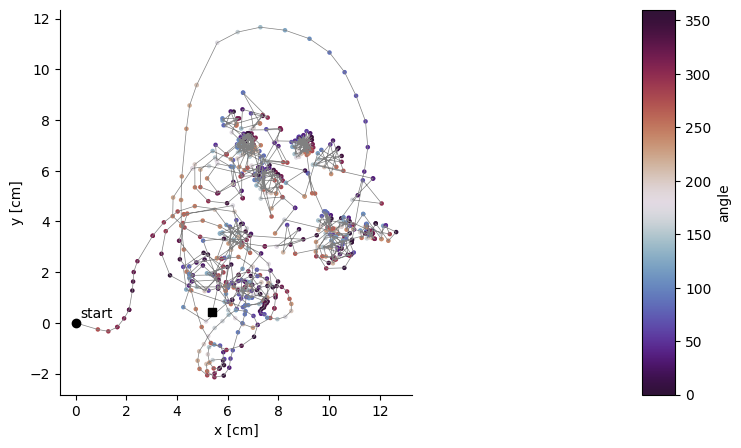

In [37]:
uvrTest.posDf = uvrTest.posDf.rename(columns = {'dx':'forward', 'dy':'right'})
posAnalysis.position(uvrTest, plot=True, rotate_by=90)

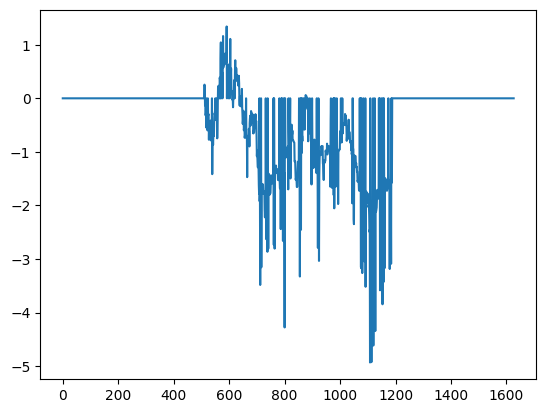

In [39]:
plt.plot(uvrTest.posDf['dx'])

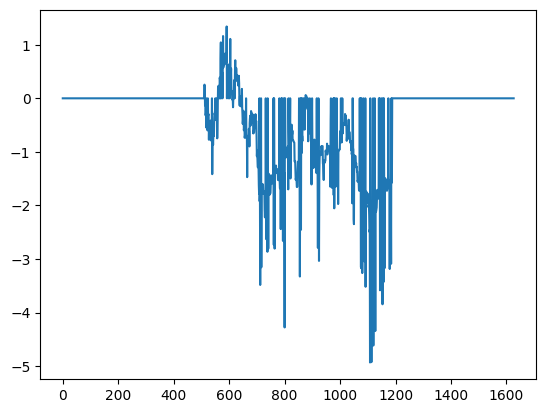

In [35]:
plt.plot(uvrTest.posDf['dx'])